In [178]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import json
import os
import pickle
import pandas as pd

def find_closest_index(time_arr, time_sampled):
    closest_indices = []
    for sample in time_sampled:
        closest_index = min(range(len(time_arr)), key=lambda i: abs(time_arr[i] - sample))
        closest_indices.append(closest_index)
    return closest_indices

def cubic_lag(t, a, b, c, t0):
    """
    Quadratic lag function.
    """

    # Only take times <= t0
    t_before = t[t <= t0]

    # Only take times > t0
    t_after = t[t > t0]

    # Compute the lag linearly before t0
    l_before = np.zeros_like(t_before)+c

    # Compute the lag quadratically after t0
    l_after = -abs(a)*(t_after - t0)**3 - abs(b)*(t_after - t0)**2 + c

    return np.concatenate((l_before, l_after))


def cubic_velocity(t, a, b, v0, t0):
    """
    Quadratic velocity function.
    """

    # Only take times <= t0
    t_before = t[t <= t0]

    # Only take times > t0
    t_after = t[t > t0]

    # Compute the velocity linearly before t0
    v_before = np.ones_like(t_before)*v0

    # Compute the velocity quadratically after t0
    v_after = -3*abs(a)*(t_after - t0)**2 - 2*abs(b)*(t_after - t0) + v0

    return np.concatenate((v_before, v_after))

def cubic_acceleration(t, a, b, t0):
    """
    Quadratic acceleration function.
    """

    # Only take times <= t0
    t_before = t[t <= t0]

    # Only take times > t0
    t_after = t[t > t0]

    # No deceleration before t0
    a_before = np.zeros_like(t_before)

    # Compute the acceleration quadratically after t0
    a_after = -6*abs(a)*(t_after - t0) - 2*abs(b)

    return np.concatenate((a_before, a_after))

def cubic_lag_NOb(t, a, c, t0):
    """
    Quadratic lag function.
    """

    # Only take times <= t0
    t_before = t[t <= t0]

    # Only take times > t0
    t_after = t[t > t0]

    # Compute the lag linearly before t0
    l_before = np.zeros_like(t_before)+c

    # Compute the lag quadratically after t0
    l_after =  -abs(a)*(t_after - t0)**3+c

    return np.concatenate((l_before, l_after))


def cubic_velocity_NOb(t, a, v0, t0):
    """
    Quadratic velocity function.
    """

    # Only take times <= t0
    t_before = t[t <= t0]

    # Only take times > t0
    t_after = t[t > t0]

    # Compute the velocity linearly before t0
    v_before = np.ones_like(t_before)*v0

    # Compute the velocity quadratically after t0
    v_after = 3*a*(t_after - t0)**2 + v0

    return np.concatenate((v_before, v_after))

def cubic_acceleration_NOb(t, a, t0):
    """
    Quadratic acceleration function.
    """

    # Only take times <= t0
    t_before = t[t <= t0]

    # Only take times > t0
    t_after = t[t > t0]

    # No deceleration before t0
    a_before = np.zeros_like(t_before)

    # Compute the acceleration quadratically after t0
    a_after = 6*a*(t_after - t0)

    return np.concatenate((a_before, a_after))

def lag_residual(params, t_time, l_data):
    """
    Residual function for the optimization.
    """

    return np.sum((l_data - cubic_lag(t_time, *params))**2)

def lag_residual_NOb(params, t_time, l_data):
    """
    Residual function for the optimization.
    """

    return np.sum((l_data - cubic_lag_NOb(t_time, *params))**2)


In [179]:
def plot_lagVel_fit(v0, time_array, lag_array_noisy, vel_array_noisy, lag_array=0, velocity_array=0):
    # Set t0 to the middle of the time array
    t0 = np.mean(time_array)

    # fit a line woith the noisty velocity data
    p = np.polyfit(time_array, vel_array_noisy, 1)
    # plot tyhe line
    initial_guess_line_aVal = np.polyval(p, time_array)

    # initial guess of deceleration decel
    decel0 = p[0]
    decel1 = p[1]

    # initial guess of acceleration a
    p0_NOb = [decel0,    0,    0]
    # p0 = [decel0, 0, 0, 0]
    p0 = [-9.24892629,	0.000148198,	-0.000802657, 0.13188390775088]

    # plot the results not in scientific notation
    np.set_printoptions(suppress=True,precision=5)
    print("Initial guess")
    print(p0)


    opt_res = opt.minimize(lag_residual, p0, args=(time_array, lag_array_noisy), method='Nelder-Mead')

    print("Optimal parameters")
    print(opt_res.x)

    a_fit, b_fit, c_fit, t0_fit = opt_res.x
    lag_array_fit = cubic_lag(time_array, a_fit, b_fit, c_fit, t0_fit)
    velocity_array_fit = cubic_velocity(time_array, a_fit,b_fit, v0, t0_fit)

    # compute reference decelearation
    t_decel_ref = (t0 + np.max(time_array))/2
    decel_ref = cubic_acceleration(t_decel_ref, a_fit, b_fit, t0_fit)[0]
    print("Deceleration at t0/2 = {:.3f} km/s^2".format(decel_ref))

    opt_res_NOb = opt.minimize(lag_residual_NOb, p0_NOb, args=(time_array, lag_array_noisy), method='Nelder-Mead')

    print("Optimal parameters NO b")
    print(opt_res_NOb.x)

    # sample the fit for the velocity and acceleration
    a_fit, c_fit, t0_fit = opt_res_NOb.x
    lag_array_fit_NOb = cubic_lag_NOb(time_array, a_fit, c_fit, t0_fit)
    velocity_array_fit_NOb = cubic_velocity_NOb(time_array, a_fit, v0, t0_fit)
    # acceleration_array_fit = cubic_acceleration_NOb(time_array, a_fit, b_fit, t0_fit)


    # plot one on top of the other
    fig, ax = plt.subplots(1, 2, figsize=(25,10))
    # ax[0].plot(time_array, length_array, label='Length')
    # ax[0].scatter(time_array, length_array_noisy, label='Length (noisy)')
    if lag_array is not 0:
        ax[0].plot(time_array, lag_array, label='Lag json')
    ax[0].scatter(time_array, lag_array_noisy, label='Lag (noisy)')
    ax[0].plot(time_array, cubic_lag(time_array, *p0), label='Lag (initial guess)', c='k')
    ax[0].plot(time_array, lag_array_fit, label='Lag (fit)', linestyle='--', c='b')
    ax[0].plot(time_array, lag_array_fit_NOb, label='Lag (fit_NOb)', linestyle='--', c='r')
    ax[0].set_ylabel('Lag (km)')
    ax[0].legend()
    if velocity_array is not 0:
        ax[1].plot(time_array, velocity_array, label='Velocity')
    ax[1].scatter(time_array, vel_array_noisy, label='Velocity (noisy)')
    ax[1].plot(time_array, cubic_velocity(time_array, p0[0], p0[1], v0 ,p0[-1]), label='Velocity (initial guess)', c='k')
    ax[1].plot(time_array, velocity_array_fit, label='Velocity (fit)', linestyle='--', c='b')
    ax[1].plot(time_array, velocity_array_fit_NOb, label='Velocity (fit_NOb)', linestyle='--', c='r')
    ax[1].plot(time_array, initial_guess_line_aVal, label='initial guess p[0]', linestyle='-.', c='k')

    # plot a parabual fit
    p = np.polyfit(time_array, vel_array_noisy, 2)
    # plot tyhe parabula
    initial_guess_par_aVal = np.polyval(p, time_array)
    ax[1].plot(time_array, initial_guess_par_aVal, label='parabolic fit', linestyle=':', c='k')

    ax[1].set_ylabel('Velocity (km/s)')
    ax[1].legend()
    plt.xlabel('Time (s)')
    plt.show()

<>:55: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:55: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\maxiv\AppData\Local\Temp\ipykernel_17740\2206387190.py:55: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lag_array is not 0:
C:\Users\maxiv\AppData\Local\Temp\ipykernel_17740\2206387190.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if velocity_array is not 0:


Initial guess
[-9.24892629, 0.000148198, -0.000802657, 0.13188390775088]
Optimal parameters
[-15.54796   0.00284  -0.00378   0.13005]
Deceleration at t0/2 = -18.484 km/s^2
Optimal parameters NO b
[-15.54793  -0.00378   0.12999]


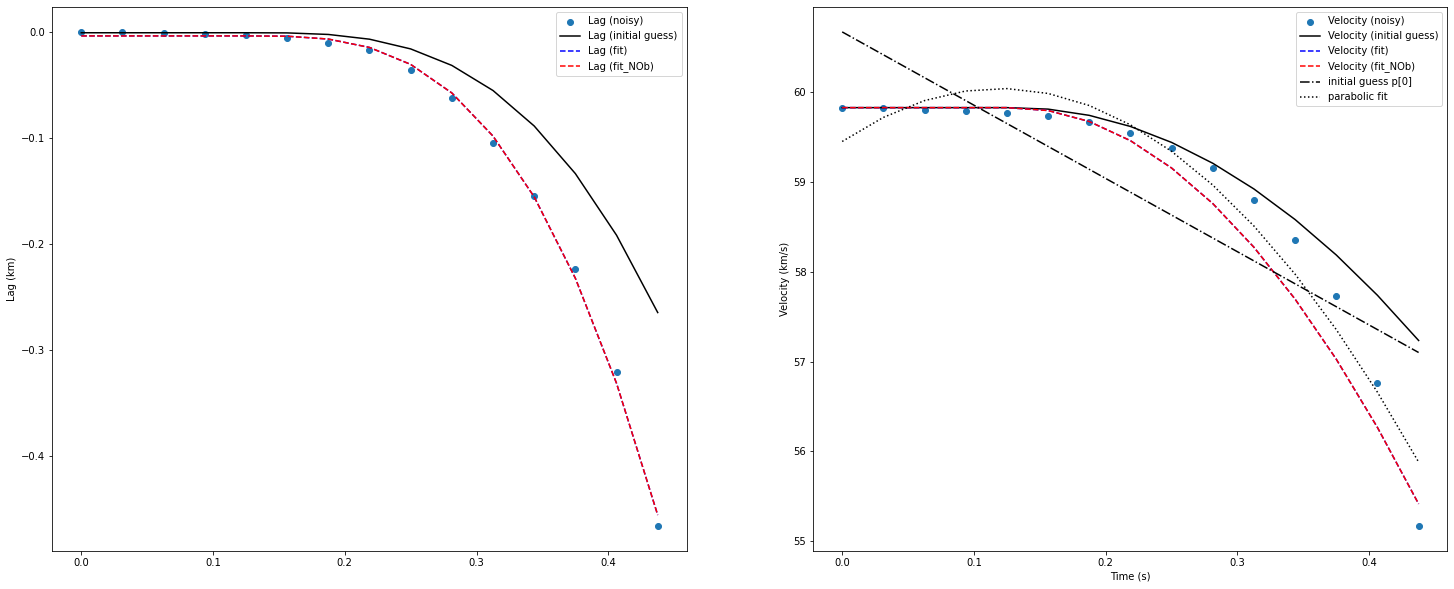

In [180]:
# read TRUEerosion_sim_v59.84_m1.33e-02g_rho0209_z39.8_abl0.014_eh117.3_er0.636_s1.61.json and get the velocity time and lenght data
# with open('TRUEerosion_sim_v59.84_m1.33e-02g_rho0209_z39.8_abl0.014_eh117.3_er0.636_s1.61.json') as f:

# v59\rho0400\erosion_sim_v59.76_m1.32e-02g_rho0489_z39.8_abl0.014_eh118.1_er0.993_s2.21.json
# rho0100\erosion_sim_v59.88_m1.27e-02g_rho0115_z39.8_abl0.014_eh117.5_er0.308_s1.64.json
with open('C:\\Users\\maxiv\\Documents\\UWO\\Papers\\1)PCA\\PCA_Error_propagation\\Simulations_PER\\v59\\rho0100\\erosion_sim_v59.88_m1.27e-02g_rho0115_z39.8_abl0.014_eh117.5_er0.308_s1.64.json') as f:
    data = json.load(f)

    vel_sim=data['simulation_results']['leading_frag_vel_arr']#['brightest_vel_arr']#['leading_frag_vel_arr']#['main_vel_arr']
    ht_sim=data['simulation_results']['leading_frag_height_arr']#['brightest_height_arr']['leading_frag_height_arr']['main_height_arr']
    time_sim=data['simulation_results']['time_arr']#['main_time_arr']
    abs_mag_sim=data['simulation_results']['abs_magnitude']
    len_sim=data['simulation_results']['brightest_length_arr']#['brightest_length_arr']

    obs_height=data['ht_sampled']

    # # find the index of the first element of the simulation that is equal to the first element of the observation
    index_ht_sim=next(x for x, val in enumerate(ht_sim) if val <= obs_height[0])
    # find the index of the last element of the simulation that is equal to the last element of the observation
    index_ht_sim_end=next(x for x, val in enumerate(ht_sim) if val <= obs_height[-1])

    abs_mag_sim=abs_mag_sim[index_ht_sim:index_ht_sim_end]
    vel_sim=vel_sim[index_ht_sim:index_ht_sim_end]
    time_sim=time_sim[index_ht_sim:index_ht_sim_end]
    ht_sim=ht_sim[index_ht_sim:index_ht_sim_end]
    len_sim=len_sim[index_ht_sim:index_ht_sim_end]

    # divide the vel_sim by 1000 considering is a list
    time_sim = [i-time_sim[0] for i in time_sim]
    vel_sim = [i/1000 for i in vel_sim]
    len_sim = [(i-len_sim[0])/1000 for i in len_sim]
    ht_sim = [i/1000 for i in ht_sim]

    # time_sim = [i-time_sim[0] for i in time_sim]
    # len_sim = [(i-len_sim[0]) for i in len_sim]

    v0 = vel_sim[0]

    # observed data from the EMCCD ############################################################
    obs_time=data['time_sampled']
    obs_length=data['len_sampled']
    abs_mag_obs=data['mag_sampled']
    obs_vel=[v0]
    obs_length=[x/1000 for x in obs_length]
    obs_height=[x/1000 for x in obs_height]
    # append from vel_sampled the rest by the difference of the first element of obs_length divided by the first element of obs_time
    rest_vel_sampled=[(obs_length[vel_ii]-obs_length[vel_ii-1])/(obs_time[vel_ii]-obs_time[vel_ii-1]) for vel_ii in range(1,len(obs_length))]
    # append the rest_vel_sampled to vel_sampled
    obs_vel.extend(rest_vel_sampled)

    # create the lag array as the difference betyween the lenght and v0*time+len_sim[0]
    obs_lag=obs_length-(v0*np.array(obs_time)+obs_length[0])

    #### pickle file data no noise ##########################################################################

    closest_indices = find_closest_index(time_sim, obs_time)

    abs_mag_sim=[abs_mag_sim[jj_index_cut] for jj_index_cut in closest_indices]
    vel_sim=[vel_sim[jj_index_cut] for jj_index_cut in closest_indices]
    time_sim=[time_sim[jj_index_cut] for jj_index_cut in closest_indices]
    ht_sim=[ht_sim[jj_index_cut] for jj_index_cut in closest_indices]
    len_sim=[len_sim[jj_index_cut] for jj_index_cut in closest_indices]

    # create the lag array as the difference betyween the lenght and v0*time+len_sim[0]
    lag_sim=len_sim-(v0*np.array(time_sim)+len_sim[0])
    ############################################################################################################



plot_lagVel_fit(v0, np.array(obs_time), np.array(lag_sim), np.array(vel_sim)) # np.array(obs_lag), np.array(obs_vel), 

Initial guess
[-9.24892629, 0.000148198, -0.000802657, 0.13188390775088]
Optimal parameters
[-16.47049  -0.0002   -0.0015    0.24955]
Deceleration at t0/2 = -12.917 km/s^2
Optimal parameters NO b
[-16.4706   -0.0015    0.24955]


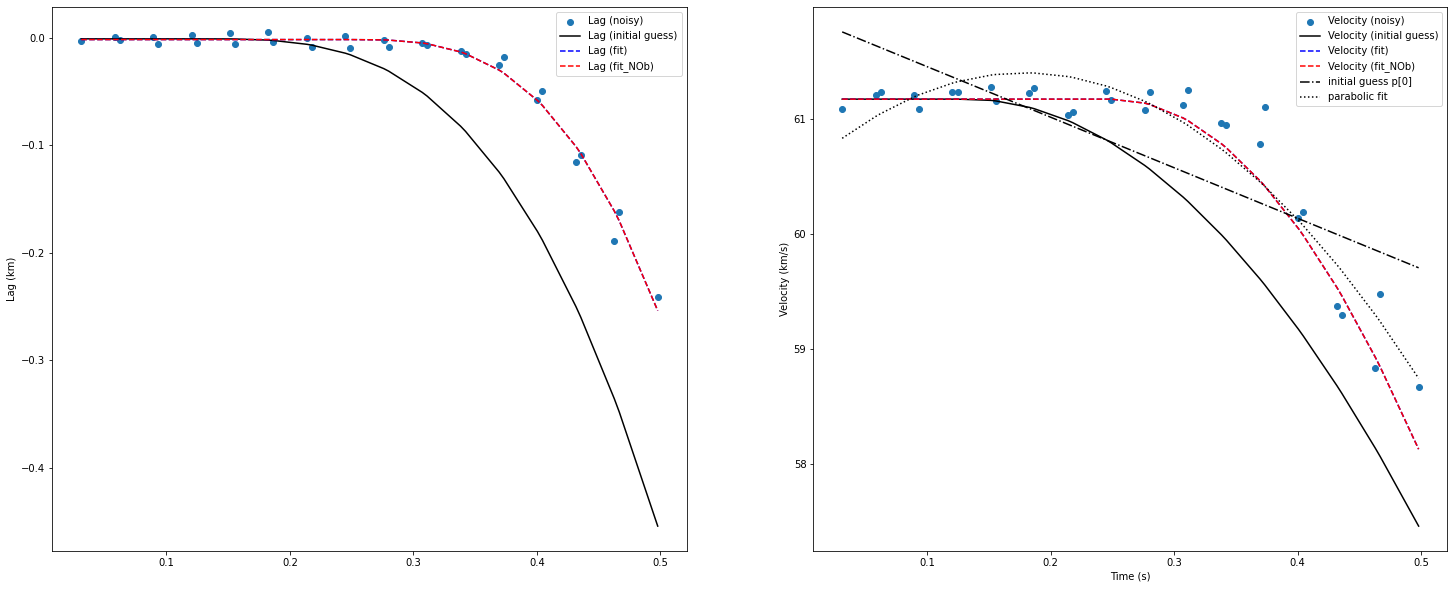

In [181]:
with open(os.path.join(os.getcwd(), "20210813_061452_trajectory.pickle"), 'rb') as f:
    traj = pickle.load(f, encoding='latin1')
# with open(os.path.join("/home/mvovk/WMPG-repoMAX/Code/PCA", "TRUEerosion_sim_v59.84_m1.33e-02g_rho0209_z39.8_abl0.014_eh117.3_er0.636_s1.61.pickle"), 'rb') as f:
#     traj = pickle.load(f, encoding='latin1')


vel_pickl=[]
time_pickl=[]
abs_mag_pickl=[]
height_pickl=[]
lag_pickle=[]

jj=0
for obs in traj.observations:
    jj+=1
    # first 4 observations of vel to define the v0
    if jj==1:
        elg_pickl=obs.velocities[1:int(len(obs.velocities)/4)]
        if len(elg_pickl)==0:
            elg_pickl=obs.velocities[1:2]
    elif jj==2:
        tav_pickl=obs.velocities[1:int(len(obs.velocities)/4)]
        if len(tav_pickl)==0:
            tav_pickl=obs.velocities[1:2]

    # put it at the end obs.velocities[1:] at the end of vel_pickl list
    vel_pickl.extend(obs.velocities[1:])
    time_pickl.extend(obs.time_data[1:])
    abs_mag_pickl.extend(obs.absolute_magnitudes[1:])
    height_pickl.extend(obs.model_ht[1:])
    lag_pickle.extend(obs.lag[1:])

v0 = (np.mean(elg_pickl)+np.mean(tav_pickl))/2/1000

# divide the lag and vel by 1000
vel_pickl = [i/1000 for i in vel_pickl]
lag_pickle = [i/1000 for i in lag_pickle]

# put all in the same panda dataframe
df = pd.DataFrame({'time': time_pickl, 'lag': lag_pickle, 'vel': vel_pickl})
df = df.sort_values(by='time')

plot_lagVel_fit(v0, np.array(df['time']), np.array(df['lag']), np.array(df['vel']))